In [1]:
torch.cuda.get_device_name(2)

NameError: name 'torch' is not defined

In [2]:
from scipy import io
import os
import pandas as pd
import numpy as np
import random

import torch
from torch_geometric.data import Data, DataLoader

import math
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import random
import numpy as np
from torch_geometric.nn import ChebConv, GCNConv
from torch_geometric.transforms import LaplacianLambdaMax
    

In [3]:
# EEG_band : delta, theta, alpha, beta, gamma, all = 1,2,3,4,5,None
# Feature_name : de_LDS, PSD_LDS, etc.
def load_data(data_dir_path,label_dir_path, trial:int, feature_name, EEG_band=None):  
    subject_data_list, session_list = [], []
    file_list = os.listdir(data_dir_path)
    
    for idx, file in enumerate(file_list):
        trial_list = []
        data = io.loadmat(data_dir_path + file)
        if EEG_band is None:
            for trial_idx in range(1, trial+1):
                trial_list.append(data[feature_name + str(trial_idx)][:, :, :])  # EEG all bands

        else:
            for trial_idx in range(1, trial+1):
                trial_list.append(data[feature_name + str(trial_idx)][:, :, EEG_band])

        session_list.append(trial_list)

        if (idx + 1) % 3 == 0:
            subject_data_list.append(session_list)
            session_list = []

    label = io.loadmat(label_dir_path + 'label.mat')['label']
    label = [1 + label[0][i] for i in range(trial)]
    #label [-1, 1] --> [0, 2]

    # subject_data_list : num_subjects(15) × num_sessions(3) × num_trials(15)
    return subject_data_list, label


# edge attributes are composed of edge weights, the distance between all EEG channel pairs
def load_edge_information(pdc_dir_path, sub_name, pdc_var_name, n_channels, n_trials, n_sessions, n_subjects):

    file_list = os.listdir(pdc_dir_path)
    
    edge_index_list = []
    for i in range(n_channels):
        for j in range(n_channels):
            edge_index_list.append([i,j])
            
    edge_attr_list = []
    session_edge_attr_list = []
    sub_idx = 0
    for i, file in enumerate(file_list):
        trial_edge_attr_list = []
        pdcs = io.loadmat(pdc_dir_path + file)
        pdc_name = sub_name[sub_idx]+pdc_var_name
        for trial_idx in range(1, n_trials+1):
            edge_attr = []
            pdc = pdcs[pdc_name+str(trial_idx)][:,:]
            for k in range(n_channels):
                for l in range(n_channels):
                    if k == l:
                        edge_attr.append(0)
                    else:
                        edge_attr.append(pdc[k][l])
        
            trial_edge_attr_list.append(edge_attr)
        session_edge_attr_list.append(trial_edge_attr_list)
        if (i+1) % 3 == 0:
            sub_idx+=1
            edge_attr_list.append(session_edge_attr_list)
            session_edge_attr_list = []

    return edge_index_list, edge_attr_list


#Graph Representation
def get_graph_data(subject_data, subject_label, edge_index_list, edge_attr_list, num_train_trials , batch_size):
    edge_index = torch.tensor(edge_index_list, dtype=torch.long)
    train_loader, test_loader = [], []

    num_subjects = len(subject_data)
    num_sessions = len(subject_data[0])
    num_trials = len(subject_data[0][0])

    for subject in range(num_subjects):
        train_dataset, test_dataset = [], []
        for session in range(num_sessions):
            for trial in range(num_trials):
                data_list = []
                trial_data = subject_data[subject][session][trial] # trial_data = [62][about 240][1or5] = [nodes][trial time][EEG band(s)]
                blocks = len(trial_data[1]) # about 240(240 sec, 4minutes), 'blocks' is number of blocks which is the same as a trial time
                edge_attr = torch.tensor(edge_attr_list[subject][session][trial], dtype=torch.float)
                for block_idx in range(blocks):
                    # if using features of all frequency bands,
                    # node_feature = [delta, theta, alpha, beta, gamma]
                    data_sample = torch.tensor(trial_data[:, block_idx, :], dtype=torch.float)#data_sample = [62][5] = [nodes, node_features(EEG band(s)]
                    data_label = torch.tensor(subject_label[trial], dtype=torch.long) # data_label [0,2]
                    data_list.append(Data(x=data_sample, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr, y=data_label))
                if trial < num_train_trials:
                    train_dataset.extend(data_list)
                else: 
                    test_dataset.extend(data_list)
            
        random.shuffle(train_dataset)
        random.shuffle(test_dataset)
        
        batch_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        batch_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        train_loader.append(batch_train_loader)
        test_loader.append(batch_test_loader)
        print('loading' + str(subject))
    print("\nTrain dataset length: {}, \tTest dataset legnth: {}".format(len(train_dataset), len(test_dataset)))
    return train_loader, test_loader


In [4]:
def criterion(loss, label, model, L1_regularization_scaler):
    l1_regularization = torch.tensor(0., device=device)
    
    for param in model.parameters():
        l1_regularization += torch.norm(param, 1)

    loss += L1_regularization_scaler * l1_regularization
    
    return loss

def train(loader, model, optimizer, L1_regularization_scaler, epoch, batch_size):
    model.train()
    train_acc, train_loss, count = 0., 0., 0.

    dataset_length = len(loader.dataset)
    loader_length = len(loader)
    for batch_idx, data in enumerate(loader):
        if len(data.y) == batch_size: # dataset size가 batch size로 안나눠지면 버림
            count += 1.
            data = data.to(device)
            loss,result = model(data, 'train')
            loss = criterion(loss, data.y, model, L1_regularization_scaler)
            loss.backward()

#             with torch.no_grad():
#                 for p in model.parameters():
#                     #p = (1-lr)*p + lr*p.grad
#                     print(p.requires_grad," row : ", p)
#                     p = p.grad
#                     print(p.requires_grad, " copy : ",p)
#                     break
#             for p in model.parameters():
#                 print(p.requires_grad, " update: ", p)
#                 break
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            pred = result.max(1, keepdim = True)[1]
            acc = pred.eq(data.y.view_as(pred)).sum().item()
            acc = 100. * acc / batch_size

            train_acc += acc

    train_acc /= count
    train_loss /= count
    return train_acc, train_loss


def test(loader, model, L1_regularization_scaler, batch_size):
    model.eval()

    count, test_loss, test_acc = 0, 0, 0
    with torch.no_grad():
        for data in loader:
            if len(data.y) == batch_size:
                count += 1
                data = data.to(device)
                output, result = model(data)
                loss = output.item()
                test_loss += loss
                
                pred = result.max(1, keepdim = True)[1]
                acc = pred.eq(data.y.view_as(pred)).sum().item()
                acc = 100. * acc / batch_size
                test_acc += acc

    test_acc /= count
    test_loss /= count
    return test_acc, test_loss

In [5]:
class SSLGCN(nn.Module):
    def __init__(self, num_nodes,num_features, gcn1_channels, gcn2_channels, gcn3_channels, fc1_channels, out_channels, edge_weight, batch_size, learnable=False):
        super(SSLGCN, self).__init__()
        self.in_channels = num_features
        self.gcn1_out_channels = gcn1_channels
        self.gcn2_out_channels = gcn2_channels
        self.gcn3_out_channels = gcn3_channels
#         self.fc1_in_channels = (gcn1_channels + gcn2_channels) * num_nodes
        self.fc1_in_channels = gcn3_channels * num_nodes
        self.fc1_out_channels = fc1_channels
        self.out_channels = out_channels
        
        self.lambdamax = LaplacianLambdaMax(None)
        self.edge_weight = nn.Parameter(edge_weight, requires_grad=learnable)
        self.batch_size = batch_size
        self.softmax = nn.Softmax(dim=1)
        self.crossentropy = nn.CrossEntropyLoss()
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.15)
        self.dropout = nn.Dropout(0.1)
        
        self.bn1d = nn.BatchNorm1d(self.in_channels)
        self.gcn1 = GCNConv(self.in_channels, self.gcn1_out_channels)
        self.gcn2 = GCNConv(self.gcn1_out_channels, self.gcn2_out_channels)
        self.gcn3 = GCNConv(self.gcn2_out_channels, self.gcn3_out_channels)
        self.fc1 = nn.Linear(self.fc1_in_channels, self.fc1_out_channels)
        self.fc2 = nn.Linear(self.fc1_out_channels, self.out_channels)
        self.fc_module = nn.Sequential(self.fc1, self.dropout, self.leakyrelu, self.fc2)
        
    def forward(self, data, _type=None):
        data.edge_attr = self.edge_weight.data.repeat(self.batch_size)
        data = self.lambdamax(data)

        if data.x.dim() == 1:
            data.x = data.x.unsqueeze(dim=1)
        
        bn = self.leakyrelu(self.bn1d(data.x))
        gcn1 = self.gcn1(bn, data.edge_index, self.leakyrelu(data.edge_attr))
        gcn2 = self.gcn2(self.leakyrelu(gcn1), data.edge_index, self.leakyrelu(data.edge_attr))
        gcn3 = self.gcn3(self.leakyrelu(gcn2), data.edge_index, self.leakyrelu(data.edge_attr))
        
        """need to be checked"""
#         gcn = torch.cat((gcn1, gcn2), 0)
        gcn = self.leakyrelu(gcn3).reshape(self.batch_size, -1)

        fc = self.fc_module(gcn)
#         print("edge: ", data.edge_attr)
#         print("data: ", data.x)
#         print("BN: ", bn)
#         print("gcn1: ", gcn1)
#         print("gcn2: ", gcn2)
#         print("gcn3: ", gcn3, gcn3.shape)
#         print("flatten: ", gcn, gcn.shape)
#         print("fc: ", fc)
        loss = self.crossentropy(fc.view(-1, self.out_channels), data.y.view(-1))
        result = self.softmax(fc)
        
        return loss, result

class DGCNN6(nn.Module): # Two GCN with Batch Normalization and LeakyReLU
    def __init__(self, num_nodes,num_features, hid_channels, out_channels, k,  edge_weight, batch_size, learnable=False):
        super(DGCNN6, self).__init__()

        self.lambdamax = LaplacianLambdaMax(None)

        self.in_channels = num_features
        self.cheb_out_channels = hid_channels

        self.fc1_in_channels = 1240
        self.fc1_out_channels = 128 # 
        self.out_channels = out_channels

        self.edge_weight = nn.Parameter(edge_weight, requires_grad=learnable)
        self.batch_size = batch_size
        self.num_nodes = num_nodes
        
        self.chebconv1 = ChebConv(self.in_channels, self.cheb_out_channels, K=k, normalization = None)
        # batch normalization
        
        self.BN1d1 = nn.BatchNorm1d(self.in_channels)
        #self.BN1d1 = nn.BatchNorm1d(self.cheb_out_channels)
        
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.15)
        
        self.fc1 = nn.Linear(self.fc1_in_channels, self.fc1_out_channels)
        self.fc2 = nn.Linear(self.fc1_out_channels, self.out_channels)
        self.fc_module = nn.Sequential(self.fc1, self.leakyrelu, self.fc2)

        
                                      
    def forward(self, data, _type=None):
        data.edge_attr = self.edge_weight.data.repeat(self.batch_size)
        data = self.lambdamax(data)

        if data.x.dim() == 1:
            data.x = data.x.unsqueeze(dim=1)
#         print(len(data.x), data.x.shape)
        
#         print("chebconv1: ",repr(self.chebconv1.lins[0].weight))
#         print("chebconv2: ",repr(self.chebconv1.lins[1].weight))
#         print("chebconv3: ",repr(self.chebconv1.lins[2].weight))
#         print("fc1: ", repr(self.fc1.weight))
#         print("fc2: ", repr(self.fc2.weight))

#         print("data: {} , size:{}".format(data.x, data.x.shape))
#         print("Edge: {}".format(data.edge_attr))
#         print("SEdge: {}".format(self.edge_weight))
#         print("BN data: {}".format(self.BN1d1(data.x)))
        data.x = self.leakyrelu(self.BN1d1(data.x))
#         print("BN data: {}".format(data.x))
        cheb_layer = self.chebconv1(data.x, data.edge_index, self.leakyrelu(data.edge_attr), lambda_max=data.lambda_max)
        #print("CHEB: {}".format(cheb_layer.shape))
        #print("CHEB: {}".format(cheb_layer))
        #print("BN: {}".format(cheb_layer.shape))
        #print("BN: {}".format(cheb_layer))
        cheb_layer = self.leakyrelu(cheb_layer).reshape(self.batch_size, -1)
        fc_layer = self.fc_module(cheb_layer)
        
        if _type == 'train':
            loss_fct = nn.CrossEntropyLoss()
#             print(fc_layer.shape, data.y.shape, fc_layer[0])
            loss = loss_fct(fc_layer.view(-1, self.out_channels), data.y.view(-1))
#             print(loss)
            logits = self.softmax(fc_layer)
            return loss, logits
        else:
            loss_fct = nn.CrossEntropyLoss()
#             print(fc_layer.shape, data.y.shape, fc_layer[0])
            loss = loss_fct(fc_layer.view(-1, self.out_channels), data.y.view(-1))
#             print(loss)
            logits = self.softmax(fc_layer)
            return loss, logits
    

In [6]:
f = open('/media/neuroai/dh/test.txt')
f.close()

FileNotFoundError: [Errno 2] No such file or directory: '/media/neuroai/dh/test.txt'

In [7]:
import time
data_dir_path = '/media/neuroai/Samsung USB/data/'
feature_name = 'de_LDS'
# data_dir_path = 'C:/Users/daehyeon/Desktop/GCN_implement/GCN_implement/dataset/SEED/SEED/ExtractedFeatures/data/'
# feature_name = 'de_LDS'
label_dir_path = '/media/neuroai/Samsung USB/label/'
channels_dir_path = '/media/neuroai/Samsung USB/requirements'

pdc_dir_path = '/media/neuroai/Samsung USB/pdcs_nodiag/'
sub_name = ['djc', 'jl', 'jj', 'lqj', 'ly', 'mhw', 'phl', 'sxy', 'wk', 'ww', 'wsf', 'wyw', 'xyl', 'ys', 'zjy'];
pdc_var_name = '_PDC_mean'



In [14]:
sessions, subjects, trials, num_nodes, num_classes, train_trials = 3, 15, 15, 62, 3, 9  # 논문과 데이터셋에서 명시된 값
epochs, freq_bands, random_seed = 100, 5, 42  # training 할 때 변경이 가능한 hyper-parameter
k, batch_size, learning_rate, lambda1 = 3, 32, 0.01, 0.001  # training 할 때 변경이 가능한 parameter
EEG_band = None
subject_data, subject_label = load_data('SSLGCN/dataset/seed/SEED_EEG/ExtractedFeatures/data/','SSLGCN/dataset/seed/SEED_EEG/ExtractedFeatures/label/', trials, feature_name, EEG_band)
edge_index_list, edge_attr_list = load_edge_information(pdc_dir_path, sub_name, pdc_var_name, num_nodes, trials, sessions, subjects)
train_loader, test_loader = get_graph_data(subject_data, subject_label,
                                 edge_index_list, edge_attr_list,
                                 train_trials , batch_size)



FileNotFoundError: [Errno 2] No such file or directory: '/media/neuroai/Samsung USB/pdcs_nodiag/'

In [ ]:
edge_attr_list

In [33]:
sub_train_loader_pdc = train_loader[4]
sub_edge_attr_pdc = sub_train_loader_dsma.dataset[4].edge_attr
sub_test_loader_pdc = test_loader[4]

In [9]:
edge_index_list, edge_attr_list = load_edge_information(pdc_dir_path,sub_name, pdc_var_name,num_nodes, trials, sessions, subjects)
train_loader, test_loader = get_graph_data(subject_data, subject_label,
                                 edge_index_list, edge_attr_list,
                                 train_trials , batch_size)


NameError: name 'pdc_dir_path' is not defined

In [26]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
learning_rate = 0.001
lambda1 = 0.0001
wd = learning_rate / 10
model6 = SSLGCN(num_nodes, freq_bands, 16, 32, 64, 128, num_classes, sub_edge_attr_pdc, batch_size, False).to(device)
#odel6 = DGCNN6(num_nodes, freq_bands, 20, num_classes, k, sub_edge_attr_pdc, batch_size, True).to(device)
optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate, weight_decay= wd)

epochs = 200
for epoch in range(1, epochs+1):
    train_acc, train_loss = train(sub_train_loader_pdc, model6, optimizer6, lambda1, epoch, batch_size)
    
    print("Train Accuracy: {:.2f}%,Train Loss: {:.4f}"
              .format(train_acc, train_loss))
    test_acc, test_loss = test(sub_test_loader_pdc.to(device), model6, lambda1, batch_size)
    print("Epoch:{}, Model6 Evaluation Result: Test Accuracy: {:.2f}%,\tTest Loss: {:.4f}"
              .format(epoch, test_acc, test_loss))

Train Accuracy: 53.69%,Train Loss: 1.1889
Epoch:1, Model6 Evaluation Result: Test Accuracy: 36.17%,	Test Loss: 1.1193
Train Accuracy: 64.53%,Train Loss: 0.9002
Epoch:2, Model6 Evaluation Result: Test Accuracy: 39.87%,	Test Loss: 1.1119
Train Accuracy: 66.59%,Train Loss: 0.8272
Epoch:3, Model6 Evaluation Result: Test Accuracy: 38.18%,	Test Loss: 1.1747
Train Accuracy: 67.77%,Train Loss: 0.7804
Epoch:4, Model6 Evaluation Result: Test Accuracy: 40.75%,	Test Loss: 1.2428
Train Accuracy: 69.55%,Train Loss: 0.7393
Epoch:5, Model6 Evaluation Result: Test Accuracy: 34.74%,	Test Loss: 1.2678
Train Accuracy: 70.79%,Train Loss: 0.7099
Epoch:6, Model6 Evaluation Result: Test Accuracy: 35.22%,	Test Loss: 1.3820
Train Accuracy: 72.64%,Train Loss: 0.6825
Epoch:7, Model6 Evaluation Result: Test Accuracy: 44.36%,	Test Loss: 1.3399
Train Accuracy: 73.39%,Train Loss: 0.6575
Epoch:8, Model6 Evaluation Result: Test Accuracy: 34.57%,	Test Loss: 1.3024
Train Accuracy: 75.03%,Train Loss: 0.6317
Epoch:9, Model

KeyboardInterrupt: 

In [ ]:
f = open("E:/pdc_result/22-08-31_PDCGCN_epoch200.txt", 'w')
f.write("DGCNN6 lr : {0.01 ~ 0.000001}, ld : {0.01, 0.0000001}\n\n")

epochs = 200
cnt = 0
learning_rate = 0.01
# prev = 0
sub_train_loader_pdc = train_loader[4]
sub_edge_attr_pdc = sub_train_loader_pdc.dataset[4].edge_attr
sub_test_loader_pdc = test_loader[4]

for lr in range (5):
    lambda1 = 0.001
    for ld in range(5):
#         learning_check = 0
        cnt+=1
        print("OK {}".format(cnt))
        w = "lr: "+str(learning_rate) + "  ld: "+str(lambda1) + "\n--------------------------------------------------------------------\n"
        f.write(w)
        model6 = SSLGCN(num_nodes, freq_bands, 16, 32, 64, 128, num_classes, sub_edge_attr_pdc, batch_size, False).to(device)
        optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate)#, weight_decay=5e-3)
        for epoch in range(1, epochs+1):
            train_acc, train_loss = train(sub_train_loader_pdc, model6, optimizer6, lambda1, epoch, batch_size)

            if epoch % 10 == 0:
                a = "Epoch: "+str(epoch)+", Train Acc: " + str(round(train_acc,2)) + ",Train Loss: " + str(round(train_loss,4)) + "\n"
                f.write(a)
            test_acc, test_loss = test(sub_test_loader_pdc, model6, lambda1, batch_size)
            b = "Epoch: "+str(epoch)+", SSLGCN Evaluation Result -  Test Accuracy: " + str(round(test_acc,2)) + ",\tTest Loss: " + str(round(test_loss,4)) + "\n\n"
            f.write(b)
            
#             if str(test_acc)[:5] == str(prev)[:5]:
#                 learning_check += 1
#             else:
#                 learning_check = 0
#             if learning_check == 8:
#                 break
                
#             prev = test_acc
        lambda1 /= 10
        f.write("------------------------------------------------------------------\n\n")
    f.write("------------------------------------------------------------------\n\n\n")
    learning_rate /= 10
    
    
f.close()

In [ ]:
f = open("E:/pdc_result/22-08-31_DGCNN_PDC_epoch200_wd.txt", 'w')
f.write("DGCNN6 lr : {0.01 ~ 0.000001}, ld : {0.01, 0.0000001}\n\n")

epochs = 200
cnt = 0
learning_rate = 0.01

model6 = DGCNN6(num_nodes, freq_bands, 20, num_classes, k, sub_edge_attr_pdc, batch_size, True).to(device)
optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate, weight_decay= wd)

sub_train_loader_pdc = train_loader[4]
sub_edge_attr_pdc = sub_train_loader_pdc.dataset[4].edge_attr
sub_test_loader_pdc = test_loader[4]
for lr in range (5):
    lambda1 = 0.001
    wd = learning_rate / 10
    for ld in range(5):
#         learning_check = 0
        cnt+=1
        print("OK {}".format(cnt))
        w = "lr: "+str(learning_rate) + "  ld: "+str(lambda1) + "\n--------------------------------------------------------------------\n"
        f.write(w)
        model6 = DGCNN6(num_nodes, freq_bands, 20, num_classes, k, sub_edge_attr_pdc, batch_size, True).to(device)
        optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate, weight_decay=wd)
        for epoch in range(1, epochs+1):
            train_acc, train_loss = train(sub_train_loader_pdc, model6, optimizer6, lambda1, epoch, batch_size)

            if epoch % 10 == 0:
                a = "Epoch: "+str(epoch)+", Train Acc: " + str(round(train_acc,2)) + ",Train Loss: " + str(round(train_loss,4)) + "\n"
                f.write(a)
            test_acc, test_loss = test(sub_test_loader_pdc, model6, lambda1, batch_size)
            b = "Epoch: "+str(epoch)+", SSLGCN Evaluation Result -  Test Accuracy: " + str(round(test_acc,2)) + ",\tTest Loss: " + str(round(test_loss,4)) + "\n\n"
            f.write(b)
            
#             if str(test_acc)[:5] == str(prev)[:5]:
#                 learning_check += 1
#             else:
#                 learning_check = 0
#             if learning_check == 8:
#                 break
                
#             prev = test_acc
        lambda1 /= 10
        f.write("------------------------------------------------------------------\n\n")
    f.write("------------------------------------------------------------------\n\n\n")
    learning_rate /= 10
    
    
f.close()

In [50]:
f = open('E:/pdc_result/test.txt', 'w')
f.write(str(best_acc[0]))
f.close()

In [63]:
f = open('E:/pdc_result/test.txt', 'w')
f.write("!!! BEST ACCURACY !!!\n   ")
f.write(str(best_acc[1]))
f.close()

In [48]:
# os.environ["CUDA_VISIBLE_DEVICES"]= "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())


True
3
NVIDIA GeForce RTX 3090


In [49]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 2 to use

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 3


In [29]:
best_acc = np.zeros((15,),float)

In [54]:
f.close()
best_acc

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 84.44767442,  0.        , 97.02034884])

In [55]:
epochs = 200

# prev = 0
# best_acc = np.zeros((15), float)

for sub in range (12,15):
    cnt = 0
    learning_rate = 0.01

    sub_train_loader_pdc = train_loader[sub]
    sub_edge_attr_pdc = sub_train_loader_pdc.dataset[sub].edge_attr
    sub_test_loader_pdc = test_loader[sub]
    len_lr = 5;
    len_ld = 5;
    f = open("/media/neuroai/Samsung USB/continue_22-08-31_sub12_DGCNN_PDC_epoch200.txt", 'w')
    
    for lr in range (len_lr):
        lambda1 = 0.001
        
        for ld in range(len_ld):
    #         learning_check = 0
            cnt+=1
            print("OK {}".format(cnt))
            w = "lr: "+str(learning_rate) + "  ld: "+str(lambda1) + "\n--------------------------------------------------------------------\n"
            f.write(w)
            model6 = DGCNN6(num_nodes, freq_bands, 20, num_classes, k, sub_edge_attr_pdc, batch_size, True).to(device)
            optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate)#, weight_decay=5e-3)
            for epoch in range(1, epochs+1):
                
                train_acc, train_loss = train(sub_train_loader_pdc, model6, optimizer6, lambda1, epoch, batch_size)

#                 if epoch % 10 == 0:
#                     a = "Epoch: "+str(epoch)+", Train Acc: " + str(round(train_acc,2)) + ",Train Loss: " + str(round(train_loss,4)) + "\n"
#                     f.write(a)
                test_acc, test_loss = test(sub_test_loader_pdc, model6, lambda1, batch_size)
                if test_acc > best_acc[sub]:
                    best_acc[sub] = test_acc
                b = "Epoch: "+str(epoch)+", Model6 Evaluation Result -  Test Accuracy: " + str(round(test_acc,2)) + ",\tTest Loss: " + str(round(test_loss,4)) + "\n\n"
                f.write(b)

    #             if str(test_acc)[:5] == str(prev)[:5]:
    #                 learning_check += 1
    #             else:
    #                 learning_check = 0
    #             if learning_check == 8:
    #                 break

    #             prev = test_acc
            lambda1 /= 10
            f.write("------------------------------------------------------------------\n\n")
        f.write("------------------------------------------------------------------\n\n\n")
        learning_rate /= 10
    f.write("!!! BEST ACCURACY !!!\n")
    f.write(str(best_acc[sub]))
    f.write("\n")
    f.close()
    
print("\n-------- Best Acc ---------------")
print(best_acc)

# f = open('E:/pdc_result/all_sub_dgcnn/22-08-31 sub_acc_mean_std', 'w')
# mean_acc = best_acc.mean()
# std_acc = best_acc.std()
# f.write("mean_acc : ")
# f.write(str(mean_acc))
# f.write("std_acc: ")
# f.write(str(std_acc))
# f.close()

# print("\n-------------------------------")
# print("mean_acc : ", mean_acc)
# print("std_acc: ", std_acc)

OK 1
OK 2
OK 3
OK 4
OK 5
OK 6
OK 7
OK 8
OK 9
OK 10
OK 11
OK 12
OK 13
OK 14
OK 15
OK 16
OK 17
OK 18
OK 19
OK 20
OK 21
OK 22
OK 23
OK 24
OK 25
OK 1
OK 2
OK 3
OK 4
OK 5
OK 6
OK 7
OK 8
OK 9
OK 10
OK 11
OK 12
OK 13
OK 14
OK 15
OK 16
OK 17
OK 18
OK 19
OK 20
OK 21
OK 22
OK 23
OK 24
OK 25
OK 1
OK 2
OK 3
OK 4
OK 5
OK 6
OK 7
OK 8
OK 9
OK 10
OK 11
OK 12
OK 13
OK 14
OK 15
OK 16
OK 17
OK 18
OK 19
OK 20
OK 21
OK 22
OK 23
OK 24
OK 25

-------- Best Acc ---------------
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          93.84689922  88.2751938  100.        ]


In [58]:
epochs = 200

# prev = 0
# best_acc = np.zeros((15), float)

for sub in range (3,4):
    cnt = 11
    learning_rate = 0.0001

    sub_train_loader_pdc = train_loader[sub]
    sub_edge_attr_pdc = sub_train_loader_pdc.dataset[sub].edge_attr
    sub_test_loader_pdc = test_loader[sub]
    len_lr = 3;
    len_ld = 5;
    f = open('/media/neuroai/Samsung USB/continue_22-08-31_sub'+str(sub+1)+'_DGCNN_PDC_epoch200.txt', 'w')

#     else:
#         f = open('E:/pdc_result/all_sub_dgcnn/22-08-31 sub' + str(sub+1) + '_DGCNN_PDC_epoch200.txt', 'w')
#         f.write("DGCNN lr : {0.01 ~ 0.000001}, ld : {0.01, 0.0000001}\n\n")
    
    
    for lr in range (len_lr):
        lambda1 = 0.001      
        if lr == 0:
            lambda1 = 0.0001
            len_ld = 4
        for ld in range(len_ld):
    #         learning_check = 0
            cnt+=1
            print("OK {}".format(cnt))
            w = "lr: "+str(learning_rate) + "  ld: "+str(lambda1) + "\n--------------------------------------------------------------------\n"
            f.write(w)
            model6 = DGCNN6(num_nodes, freq_bands, 20, num_classes, k, sub_edge_attr_pdc, batch_size, True).to(device)
            optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate)#, weight_decay=5e-3)
            for epoch in range(1, epochs+1):
                train_acc, train_loss = train(sub_train_loader_pdc, model6, optimizer6, lambda1, epoch, batch_size)

                if epoch % 10 == 0:
                    a = "Epoch: "+str(epoch)+", Train Acc: " + str(round(train_acc,2)) + ",Train Loss: " + str(round(train_loss,4)) + "\n"
                    f.write(a)
                test_acc, test_loss = test(sub_test_loader_pdc, model6, lambda1, batch_size)
                if test_acc > best_acc[sub]:
                    best_acc[sub] = test_acc
                b = "Epoch: "+str(epoch)+", Model6 Evaluation Result -  Test Accuracy: " + str(round(test_acc,2)) + ",\tTest Loss: " + str(round(test_loss,4)) + "\n\n"
                f.write(b)

    #             if str(test_acc)[:5] == str(prev)[:5]:
    #                 learning_check += 1
    #             else:
    #                 learning_check = 0
    #             if learning_check == 8:
    #                 break

    #             prev = test_acc
            lambda1 /= 10
            f.write("------------------------------------------------------------------\n\n")
        f.write("------------------------------------------------------------------\n\n\n")
        learning_rate /= 10
    f.write("!!! BEST ACCURACY !!!\n")
    f.write(str(best_acc[sub]))
    f.write("\n")
    f.close()
    
print("\n-------- Best Acc ---------------")
print(best_acc)

f = open('E:/pdc_result/all_sub_dgcnn/22-08-31 sub_acc_mean_std', 'w')
mean_acc = best_acc.mean()
std_acc = best_acc.std()
f.write("mean_acc : ", str(mean_acc))
f.write("std_acc: ", str(std_acc))
f.close()

print("\n-------------------------------")
print("mean_acc : ", mean_acc)
print("std_acc: ", std_acc)





OK 12
OK 13
OK 14
OK 15
OK 16
OK 17
OK 18
OK 19
OK 20
OK 21
OK 22
OK 23

-------- Best Acc ---------------
[  0.           0.           0.          82.17054264   0.
   0.           0.           0.           0.           0.
   0.           0.          93.84689922  88.2751938  100.        ]


FileNotFoundError: [Errno 2] No such file or directory: 'E:/pdc_result/all_sub_dgcnn/22-08-31 sub_acc_mean_std'

In [59]:
epochs = 200

# prev = 0
# best_acc = np.zeros((15), float)
for sub in range (4,5):
    cnt = 0
    learning_rate = 0.01

    sub_train_loader_pdc = train_loader[sub]
    sub_edge_attr_pdc = sub_train_loader_pdc.dataset[sub].edge_attr
    sub_test_loader_pdc = test_loader[sub]
    len_lr = 1;
    len_ld = 1;
    f = open('/media/neuroai/Samsung USB/continue_22-08-31_sub'+str(sub+1)+'_DGCNN_PDC_epoch200.txt', 'w')

#     else:
#         f = open('E:/pdc_result/all_sub_dgcnn/22-08-31 sub' + str(sub+1) + '_DGCNN_PDC_epoch200.txt', 'w')
#         f.write("DGCNN lr : {0.01 ~ 0.000001}, ld : {0.01, 0.0000001}\n\n")
    
    
    for lr in range (len_lr):
        lambda1 = 0.0000001      
        for ld in range(len_ld):
    #         learning_check = 0
            cnt+=1
            print("OK {}".format(cnt))
            w = "lr: "+str(learning_rate) + "  ld: "+str(lambda1) + "\n--------------------------------------------------------------------\n"
            f.write(w)
            model6 = DGCNN6(num_nodes, freq_bands, 20, num_classes, k, sub_edge_attr_pdc, batch_size, True).to(device)
            optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate)#, weight_decay=5e-3)
            for epoch in range(1, epochs+1):
                train_acc, train_loss = train(sub_train_loader_pdc, model6, optimizer6, lambda1, epoch, batch_size)

                if epoch % 10 == 0:
                    a = "Epoch: "+str(epoch)+", Train Acc: " + str(round(train_acc,2)) + ",Train Loss: " + str(round(train_loss,4)) + "\n"
                    f.write(a)
                test_acc, test_loss = test(sub_test_loader_pdc, model6, lambda1, batch_size)
                if test_acc > best_acc[sub]:
                    best_acc[sub] = test_acc
                b = "Epoch: "+str(epoch)+", Model6 Evaluation Result -  Test Accuracy: " + str(round(test_acc,2)) + ",\tTest Loss: " + str(round(test_loss,4)) + "\n\n"
                f.write(b)

    #             if str(test_acc)[:5] == str(prev)[:5]:
    #                 learning_check += 1
    #             else:
    #                 learning_check = 0
    #             if learning_check == 8:
    #                 break

    #             prev = test_acc
            lambda1 /= 10
            f.write("------------------------------------------------------------------\n\n")
        f.write("------------------------------------------------------------------\n\n\n")
        learning_rate /= 10
    f.write("!!! BEST ACCURACY !!!\n")
    f.write(str(best_acc[sub]))
    f.write("\n")
    f.close()
    
print("\n-------- Best Acc ---------------")
print(best_acc)

for sub in range (4,5):
    cnt = 0
    learning_rate = 0.00001

    sub_train_loader_pdc = train_loader[sub]
    sub_edge_attr_pdc = sub_train_loader_pdc.dataset[sub].edge_attr
    sub_test_loader_pdc = test_loader[sub]
    len_lr = 3;
    len_ld = 5;
    f = open('/media/neuroai/Samsung USB/continue_22-08-31_sub'+str(sub+1)+'_DGCNN_PDC_epoch200.txt', 'w')

#     else:
#         f = open('E:/pdc_result/all_sub_dgcnn/22-08-31 sub' + str(sub+1) + '_DGCNN_PDC_epoch200.txt', 'w')
#         f.write("DGCNN lr : {0.01 ~ 0.000001}, ld : {0.01, 0.0000001}\n\n")
    
    
    for lr in range (len_lr):
        lambda1 = 0.001      
        for ld in range(len_ld):
    #         learning_check = 0
            cnt+=1
            print("OK {}".format(cnt))
            w = "lr: "+str(learning_rate) + "  ld: "+str(lambda1) + "\n--------------------------------------------------------------------\n"
            f.write(w)
            model6 = DGCNN6(num_nodes, freq_bands, 20, num_classes, k, sub_edge_attr_pdc, batch_size, True).to(device)
            optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate)#, weight_decay=5e-3)
            for epoch in range(1, epochs+1):
                train_acc, train_loss = train(sub_train_loader_pdc, model6, optimizer6, lambda1, epoch, batch_size)

                if epoch % 10 == 0:
                    a = "Epoch: "+str(epoch)+", Train Acc: " + str(round(train_acc,2)) + ",Train Loss: " + str(round(train_loss,4)) + "\n"
                    f.write(a)
                test_acc, test_loss = test(sub_test_loader_pdc, model6, lambda1, batch_size)
                if test_acc > best_acc[sub]:
                    best_acc[sub] = test_acc
                b = "Epoch: "+str(epoch)+", Model6 Evaluation Result -  Test Accuracy: " + str(round(test_acc,2)) + ",\tTest Loss: " + str(round(test_loss,4)) + "\n\n"
                f.write(b)

    #             if str(test_acc)[:5] == str(prev)[:5]:
    #                 learning_check += 1
    #             else:
    #                 learning_check = 0
    #             if learning_check == 8:
    #                 break

    #             prev = test_acc
            lambda1 /= 10
            f.write("------------------------------------------------------------------\n\n")
        f.write("------------------------------------------------------------------\n\n\n")
        learning_rate /= 10
    f.write("!!! BEST ACCURACY !!!\n")
    f.write(str(best_acc[sub]))
    f.write("\n")
    f.close()
    
print("\n-------- Best Acc ---------------")
print(best_acc)

f = open('E:/pdc_result/all_sub_dgcnn/22-08-31 sub_acc_mean_std', 'w')
mean_acc = best_acc.mean()
std_acc = best_acc.std()
f.write("mean_acc : ", str(mean_acc))
f.write("std_acc: ", str(std_acc))
f.close()

print("\n-------------------------------")
print("mean_acc : ", mean_acc)
print("std_acc: ", std_acc)





OK 1

-------- Best Acc ---------------
[  0.           0.           0.          82.17054264  80.42635659
   0.           0.           0.           0.           0.
   0.           0.          93.84689922  88.2751938  100.        ]
OK 1
OK 2
OK 3
OK 4
OK 5
OK 6
OK 7
OK 8
OK 9
OK 10
OK 11


KeyboardInterrupt: 

In [61]:
best_acc

array([  0.        ,   0.        ,   0.        ,  82.17054264,
        83.96317829,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        93.84689922,  88.2751938 , 100.        ])

In [12]:
"""DE and DDE, or DE and PSD, or DE, PSD, and DDE"""
"""SSM construction, fusion, and enhancement"""
"""-Parallel- concatenation of two EEG features"""

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as stds
from sklearn.neighbors import NearestNeighbors as knn
import math

def Sum_Neighbor_Value(matrix, n_nbrs=2, return_indices = False):#, agrtm='auto'):
#     dt = type(matrix)
#     if dt == 'pandas.core.frame.DataFrame':
#         matrix = np.array(matrix).tolist()
#     elif dt == 'torch.Tensor' or 'numpy.ndarray':
#         matrix = matrix.tolist()
#     else:
#         print("***** ERROR ***** \n   "" Unsupported data type ** \n support\n 1. list\n2. numpy.ndarray\n3. pandas.core.fram.DataFrame\n4. torch.Tensor\n recommended data type: 'list' ")
    
    """수정해야댐 i = 1일 때 1번째 행에서 62개의 열, 즉 길이가 62인 벡터에서 네이버 찾고
        i = 2일 때 2번째 행에서 62개의 열에서 찾고 ....
        총 62 x 2의 인덱스 매트릭스가 만들어져야 함
        나중에 i = 1일 때 네이버와 4일 때 네이버를 찾고 싶다면
        그 인덱스 값은 indices[1][:], indices[4][:]가 됨
        그리고 해당 값들은 matrix[1][indices[1][x]], matrix[4][indices[4][y]]가 됨"""
    
    n_channels = matrix.shape[0]
    sum_neighbor_value = np.zeros((n_channels), float)
    
    if return_indices == False:        
        for i in range(n_channels):
            similarities_to_ith_node = matrix[i]
            sorted_values = sorted(similarities_to_ith_node, reverse=False)
            sum_neighbor_value[i] = sum(sorted_values[:n_nbrs])
            for j in range(n_nbrs):
                neighbor_indices[j] = sorted_values[j]
        return sum_neighbor_value
    
    else:
        neighbor_indices = np.zeros((n_channels, n_nbrs), float)
        
        for i in range(n_channels):
            similarities_to_ith_node = matrix[i]
            for j in range(n_nbrs):
                min_index = similarities_to_ith_node.argmin()
                neighbor_indices[i][j] = min_index
                sum_neighbor_value[i] += similarities_to_ith_node[min_index]
                similarities_to_ith_node[min_index] = float('inf')

        return sum_neighbor_value, neighbor_indices
    

#     values = matrix.reshape(matrix.size)
#     nbrs = knn(n_neighbors = n_nbrs, algorithm = agrtm).fit(values)
#     indices = nbrs.kneighbors(values,return_distance=false)
    
#     return values, indices

    

def SSM_Construction(data, n_channels):
    ssm = np.zeros((n_channels,n_channels), dtype = float)
    data_len = len(data[0])
    data = np.array(data)
    
    for i in range(n_channels):
        for j in range(n_channels):
            if i == j: continue
            euclidean_distance = 0
            euclidean_distance = sum((data[j]-data[i])**2)**0.5
            sum_euclidean_distances += euclidean_distance
            ssm[i][j] = euclidean_distance
    mean_euclidean_distances = sum_euclidean_distances(n_channels*(n_channels-1))
    ssm /= -(0.05*mean_euclidean_distances)
    ssm = np.exp(ssm)

    pssm = np.zeros((n_channels, n_channels), dtype = float) #ssm probablity matrix
    for k in range(n_channels):
        sum_row = sum(ssm[k][:])
        pssm[k][:] = ssm[k][:] / sum_row
    
    """need to get a feedback from professor"""
    n_nbrs = 2
    values = Sum_Neighbor_Value(ssm, n_nbrs, return_indices = False) # n_channels X n_nbrs matrix
    skm = np.zeros((n_channels, n_channels), dtype = float) #sparse kernel matrix
    for k in range(n_channels):
        for l in range(n_channels):
            skm[k][l] = ssm[k][l] / values[k]
    
    return pssm, skm

def SSM_Fusion(p1,p2,sk1,sk2,iterator): # p: pssm, sk: skm    
    for i in range(iterator):
        p1 = sk1*p1*sk1.T
        p2 = sk2*p2*sk2.T
    return (p1+p2)/2

def SSM_Enhancement(fwm, n_channels, weight, iterator): # fwm : fused weight matrix
    """need to get a feedback from professor"""
    n_nbrs = 3
    values = Sum_Neighbor_Value(fwm, n_nbrs, return_indices)
    k2ssm = np.zeros((n_channels, n_channels), dtype = float) #ssm normalized with k2-based knn
    for i in range(n_channels):
        for j in range(n_channels):
            k2ssm[i][j] = ssm[i][j] / values[i]
            
    lnm = np.zeors((n_channels,n_channels), dtype = float) # localized network matrix
    for k in range(n_channels):
        for l in range(n_channels):
            for m in range(n_channels):
                lnm[k][l] += k2ssm[k][m]*k2ssm[l][m]/sum(k2ssm[:][m])
    
    values, indices = Sum_Neighbor_Value(ssm, n_nbrs = 3, return_indices = True)
    for t in range(iterator):
        essm = np.zeros((n_channels, n_channels), dtype = float)
        for i in range(n_channels):
            for j in range(n_channels):
                for q in indices[i]:
                    q1 = lnm[i][q]
                    for p in indices[j]:
                        q2 = lnm[p][j]
                        essm[i][j] += q1*ssm[q][p]*q2
            essm[i][j] = weight*essm[i][j] + (1-weight)*lnm[i][j]
        ssm = essm
    
    return essm

def Input_Generator(fm1, fm2, num_components): # fm means feature matrix
    """fm1 and fm2 need to be flatten"""
    # fv means feature vector
    
    # The large scale variable affects the principal components more
    # if the difference of scale among variables is larger
    # , so they need to be normalized as standard normal distribution, etc.
    fm1 = stds().fit_transform(fm1) # stds means standardscaler
    fm2 = stds().fit_transform(fm2)
    
    pca = PCA(n_components = num_components)
    f1_pca = pca.fit_transform(fv1) # pca result of feature1
    f2_pca = pca.fit_transform(fv2)
    
    result_fm = torch.cat((f1_pca, f2_pca), 0)
    result_ssm = SSM(f1_pca, f2_pca) # ssm means Sample-by-Sample Similarity Matrix
    
    return result_fm, result_ssm


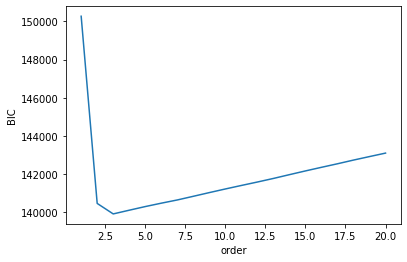

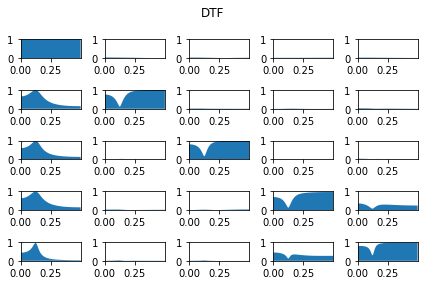

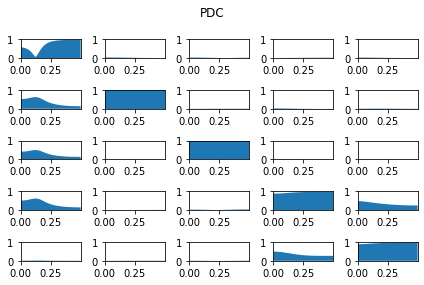

In [8]:
"""Implements Partial Directed Coherence and Direct Transfer Function
using MVAR processes.
Reference
---------
Luiz A. Baccala and Koichi Sameshima. Partial directed coherence:
a new concept in neural structure determination.
Biological Cybernetics, 84(6):463:474, 2001.
"""

# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

import math
import numpy as np
from scipy import linalg, fftpack
import matplotlib.pyplot as plt


def mvar_generate(A, n, sigma, burnin=500):
    """Simulate MVAR process
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    n : int
        The number of time samples.
    sigma : array, shape (N,)
        The noise for each time series
    burnin : int
        The length of the burnin period (in samples).
    Returns
    -------
    X : ndarray, shape (N, n)
        The N time series of length n
    """
    p, N, N = A.shape
    A_2d = np.concatenate(A, axis=1)
    Y = np.zeros((n + burnin, N))

    sigma = np.diag(sigma)
    mu = np.zeros(N)

    # itération du processus
    for i in range(p, n):
        w = np.random.multivariate_normal(mu, sigma)
        Y[i] = np.dot(A_2d, Y[i - p:i][::-1, :].ravel()) + w

    return Y[burnin:].T


def cov(X, p):
    """vector autocovariance up to order p
    Parameters
    ----------
    X : ndarray, shape (N, n)
        The N time series of length n
    Returns
    -------
    R : ndarray, shape (p + 1, N, N)
        The autocovariance up to order p
    """
    N, n = X.shape
    R = np.zeros((p + 1, N, N))
    for k in range(p + 1):
        R[k] = (1. / float(n - k)) * np.dot(X[:, :n - k], X[:, k:].T)
    return R


def mvar_fit(X, p):
    """Fit MVAR model of order p using Yule Walker
    Parameters
    ----------
    X : ndarray, shape (N, n)
        The N time series of length n
    n_fft : int
        The length of the FFT
    Returns
    -------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    sigma : array, shape (N,)
        The noise for each time series
    """
    N, n = X.shape
    gamma = cov(X, p)  # gamma(r,i,j) cov between X_i(0) et X_j(r)
    G = np.zeros((p * N, p * N))
    gamma2 = np.concatenate(gamma, axis=0)
    gamma2[:N, :N] /= 2.

    for i in range(p):
        G[N * i:, N * i:N * (i + 1)] = gamma2[:N * (p - i)]

    G = G + G.T  # big block matrix

    gamma4 = np.concatenate(gamma[1:], axis=0)

    phi = linalg.solve(G, gamma4)  # solve Yule Walker

    tmp = np.dot(gamma4[:N * p].T, phi)
    sigma = gamma[0] - tmp - tmp.T + np.dot(phi.T, np.dot(G, phi))

    phi = np.reshape(phi, (p, N, N))
    for k in range(p):
        phi[k] = phi[k].T

    return phi, sigma


def compute_order(X, p_max):
    """Estimate AR order with BIC
    Parameters
    ----------
    X : ndarray, shape (N, n)
        The N time series of length n
    p_max : int
        The maximum model order to test
    Returns
    -------
    p : int
        Estimated order
    bic : ndarray, shape (p_max + 1,)
        The BIC for the orders from 0 to p_max.
    """
    N, n = X.shape

    bic = np.empty(p_max + 1)
    bic[0] = np.inf # XXX

    Y = X.T

    for p in range(1, p_max + 1):
        A, sigma = mvar_fit(X, p)
        A_2d = np.concatenate(A, axis=1)

        n_samples = n - p
        bic[p] = n_samples * N * math.log(2. * math.pi)
        bic[p] += n_samples * np.log(linalg.det(sigma))
        bic[p] += p * (N ** 2) * math.log(n_samples)

        sigma_inv = linalg.inv(sigma)
        S = 0.
        for i in range(p, n):
            res = Y[i] - np.dot(A_2d, Y[i - p:i][::-1, :].ravel())
            S += np.dot(res, sigma_inv.dot(res))

        bic[p] += S

    p = np.argmin(bic)
    return p, bic


def spectral_density(A, n_fft=None):
    """Estimate PSD from AR coefficients
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    n_fft : int
        The length of the FFT
    Returns
    -------
    fA : ndarray, shape (n_fft, N, N)
        The estimated spectral density.
    """
    p, N, N = A.shape
    if n_fft is None:
        n_fft = max(int(2 ** math.ceil(np.log2(p))), 512)
    A2 = np.zeros((n_fft, N, N))
    A2[1:p + 1, :, :] = A  # start at 1 !
    fA = fftpack.fft(A2, axis=0)
    freqs = fftpack.fftfreq(n_fft)
    I = np.eye(N)

    for i in range(n_fft):
        fA[i] = linalg.inv(I - fA[i])

    return fA, freqs


def DTF(A, sigma=None, n_fft=None):
    """Direct Transfer Function (DTF)
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    sigma : array, shape (N, )
        The noise for each time series
    n_fft : int
        The length of the FFT
    Returns
    -------
    D : ndarray, shape (n_fft, N, N)
        The estimated DTF
    """
    p, N, N = A.shape

    if n_fft is None:
        n_fft = max(int(2 ** math.ceil(np.log2(p))), 512)

    H, freqs = spectral_density(A, n_fft)
    D = np.zeros((n_fft, N, N))

    if sigma is None:
        sigma = np.ones(N)

    for i in range(n_fft):
        S = H[i]
        V = (S * sigma[None, :]).dot(S.T.conj())
        V = np.abs(np.diag(V))
        D[i] = np.abs(S * np.sqrt(sigma[None, :])) / np.sqrt(V)[:, None]

    return D, freqs


def PDC(A, sigma=None, n_fft=None):
    """Partial directed coherence (PDC)
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    sigma : array, shape (N,)
        The noise for each time series.
    n_fft : int
        The length of the FFT.
    Returns
    -------
    P : ndarray, shape (n_fft, N, N)
        The estimated PDC.
    """
    p, N, N = A.shape

    if n_fft is None:
        n_fft = max(int(2 ** math.ceil(np.log2(p))), 512)

    H, freqs = spectral_density(A, n_fft)
    P = np.zeros((n_fft, N, N))

    if sigma is None:
        sigma = np.ones(N)

    for i in range(n_fft):
        B = H[i]
        B = linalg.inv(B)
        V = np.abs(np.dot(B.T.conj(), B * (1. / sigma[:, None])))
        V = np.diag(V)  # denominator squared
        P[i] = np.abs(B * (1. / np.sqrt(sigma))[None, :]) / np.sqrt(V)[None, :]

    return P, freqs


def plot_all(freqs, P, name):
    """Plot grid of subplots
    """
    m, N, N = P.shape
    pos_freqs = freqs[freqs >= 0]

    f, axes = plt.subplots(N, N)
    for i in range(N):
        for j in range(N):
            axes[i, j].fill_between(pos_freqs, P[freqs >= 0, i, j], 0)
            axes[i, j].set_xlim([0, np.max(pos_freqs)])
            axes[i, j].set_ylim([0, 1])
    plt.suptitle(name)
    plt.tight_layout()


if __name__ == '__main__':
    plt.close('all')

    # example from the paper
    A = np.zeros((3, 5, 5))
    A[0, 0, 0] = 0.95 * math.sqrt(2)
    A[1, 0, 0] = -0.9025
    A[1, 1, 0] = 0.5
    A[2, 2, 0] = -0.4
    A[1, 3, 0] = -0.5
    A[0, 3, 3] = 0.25 * math.sqrt(2)
    A[0, 3, 4] = 0.25 * math.sqrt(2)
    A[0, 4, 3] = -0.25 * math.sqrt(2)
    A[0, 4, 4] = 0.25 * math.sqrt(2)

    # simulate processes
    n = 10 ** 4
    # sigma = np.array([0.0001, 1, 1, 1, 1])
    # sigma = np.array([0.01, 1, 1, 1, 1])
    sigma = np.array([1., 1., 1., 1., 1.])
    Y = mvar_generate(A, n, sigma)

    mu = np.mean(Y, axis=1)
    X = Y - mu[:, None]

    # estimate AR order with BIC
    if 1:
        p_max = 20
        p, bic = compute_order(X, p_max=p_max)

        plt.figure()
        plt.plot(np.arange(p_max + 1), bic)
        plt.xlabel('order')
        plt.ylabel('BIC')
        plt.show()
    else:
        p = 3

    A_est, sigma = mvar_fit(X, p)
    sigma = np.diag(sigma)  # DTF + PDC support diagonal noise
    # sigma = None

    # compute DTF
    D, freqs = DTF(A_est, sigma)
    plot_all(freqs, D, 'DTF')

    # compute PDC
    P, freqs = PDC(A_est, sigma)
    plot_all(freqs, P, 'PDC')
    plt.show()

In [5]:
p1 = np.array([[1,2,],[2,1]])
p2 = np.array([[1,2,],[2,1]])
k1 = np.array([[1,2,],[2,1]])
k2= np.array([[1,2,],[2,1]])
SSM_Fusion(p1,p2,k1,k2,5)

[[1 8]
 [8 1]]
[[1 8]
 [8 1]]
[[ 1 32]
 [32  1]]
[[ 1 32]
 [32  1]]
[[  1 128]
 [128   1]]
[[  1 128]
 [128   1]]
[[  1 512]
 [512   1]]
[[  1 512]
 [512   1]]
[[   1 2048]
 [2048    1]]
[[   1 2048]
 [2048    1]]
